In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [2]:
photon_data = h5py.File("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5")
electron_data = h5py.File("SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5")

In [3]:
x = np.concatenate((photon_data['X'], electron_data['X']), axis=0)
y = np.concatenate((photon_data['y'], electron_data['y']), axis=0)
indices = np.random.permutation(len(x))
x = x[indices]
y = y[indices]
x = np.array(tf.image.per_image_standardization(x))


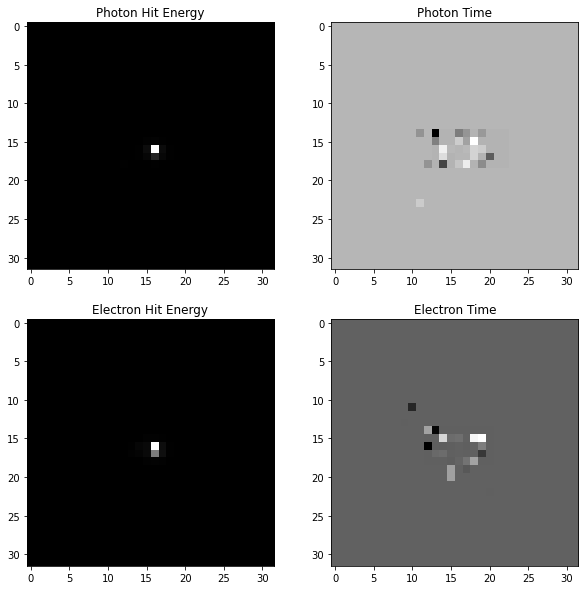

In [4]:
# plotting the two channels – hit energy and time – of the photon and electron

photon_indices = np.where(y == 0)[0]
electron_indices = np.where(y == 1)[0]

photon_energy = x[photon_indices, :, :, 0]
photon_time = x[photon_indices, :, :, 1]
electron_energy = x[electron_indices, :, :, 0]
electron_time = x[electron_indices, :, :, 1]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(photon_energy[0], cmap="gray")
ax[0, 0].set_title("Photon Hit Energy")
ax[0, 1].imshow(photon_time[0], cmap="gray")
ax[0, 1].set_title("Photon Time")
ax[1, 0].imshow(electron_energy[0], cmap="gray") 
ax[1, 0].set_title("Electron Hit Energy")
ax[1, 1].imshow(electron_time[0], cmap="gray")
ax[1, 1].set_title("Electron Time")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

# for model evaluation, I use a smaller subset of the data to accelerate the training process.

x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [10]:
# create cnn that takes in the image and outputs a probability of it being a photon or electron (where photon is 0 and electron is 1). Note that the data has the shape (32, 32, 2) – as in, a 32 by 32 matrix with two channels, one for hit 
# energy, and one for time.

# create the model
model = tf.keras.models.Sequential()

# add the first convolutional layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 2)))

# add the second convolutional layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))

# add a max pooling layer
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add a dropout layer
model.add(tf.keras.layers.Dropout(0.25))

# add a flatten layer
model.add(tf.keras.layers.Flatten())

# add a dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

# add a dropout layer
model.add(tf.keras.layers.Dropout(0.5))

# add the output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy', tf.keras.metrics.AUC()])

In [12]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
225/225 [==============================] - 5s 24ms/step - loss: 0.6737 - accuracy: 0.5835 - auc_1: 0.6169 - val_loss: 0.6642 - val_accuracy: 0.6000 - val_auc_1: 0.6380
Epoch 2/10
225/225 [==============================] - 5s 24ms/step - loss: 0.6594 - accuracy: 0.6003 - auc_1: 0.6458 - val_loss: 0.6559 - val_accuracy: 0.6187 - val_auc_1: 0.6571
Epoch 3/10
225/225 [==============================] - 5s 24ms/step - loss: 0.6463 - accuracy: 0.6239 - auc_1: 0.6722 - val_loss: 0.6587 - val_accuracy: 0.6075 - val_auc_1: 0.6484
Epoch 4/10
225/225 [==============================] - 7s 31ms/step - loss: 0.6334 - accuracy: 0.6378 - auc_1: 0.6921 - val_loss: 0.6698 - val_accuracy: 0.5962 - val_auc_1: 0.6262
Epoch 5/10
225/225 [==============================] - 6s 29ms/step - loss: 0.6096 - accuracy: 0.6589 - auc_1: 0.7231 - val_loss: 0.6679 - val_accuracy: 0.6000 - val_auc_1: 0.6288
Epoch 6/10
225/225 [==============================] - 6s 27ms/step - loss: 0.5869 - accuracy: 0.6826 - au

Evaluating the model on another subset of the data

In [11]:
x_test = x[10000:]
y_test = y[10000:]

predictions = model.predict(x_test)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15250/15250 [==============================] - 359s 23ms/step


In [76]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,predictions)

In [77]:
auc

0.6038397020729735